## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

USERNAME: chrisrle NAME: Chris René Lerner

### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html 

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": 
- https://www.uio.no/english/studies/examinations/cheating/index.html 

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2
If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [2]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [3]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [4]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [5]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

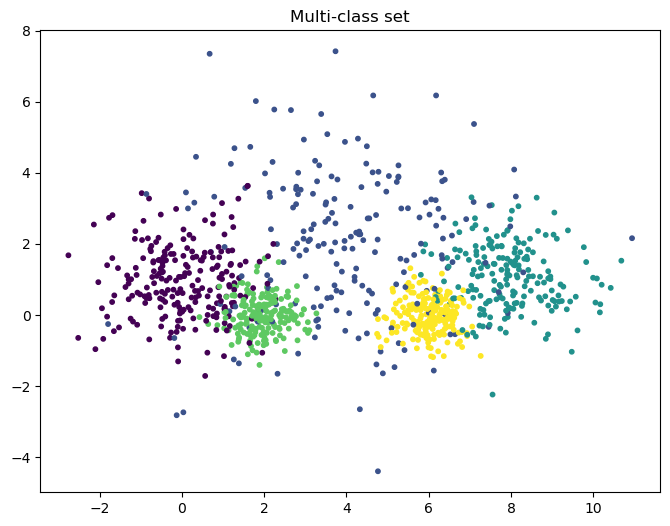

In [6]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

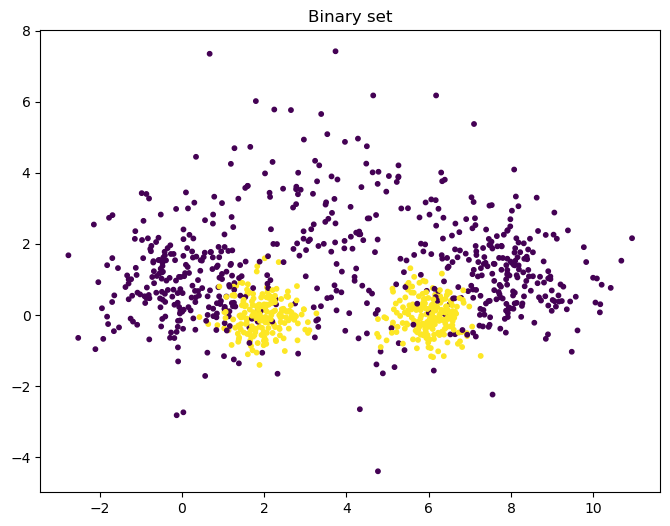

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [8]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [9]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def MSE(self, X, t, weights):
        N = X.shape[0]
        error = X @weights - t
        MSE = (1/N) * error.T @ error
        return MSE
    

In [10]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        X_train_old = X_train
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, m) = X_train.shape
        
        self.weights = weights = np.zeros(m)
        
        # Used for Task: loss
        self.loss = []
        self.accuracies = []
        
        for e in range(epochs):
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)
            
            # Calculatin loss with MSE
            error =  t_train - X_train @ weights
            MSE = (1 / N) * (error.T @ error)
            self.loss.append(MSE)
            
            # Calculating accuracy
            accuracy = np.mean(self.predict(X_train_old) == t_train)
            self.accuracies.append(accuracy)
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [11]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [12]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, eta=0.1, epochs=10)
accuracy(cl.predict(X_val), t2_val)

0.522

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [13]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

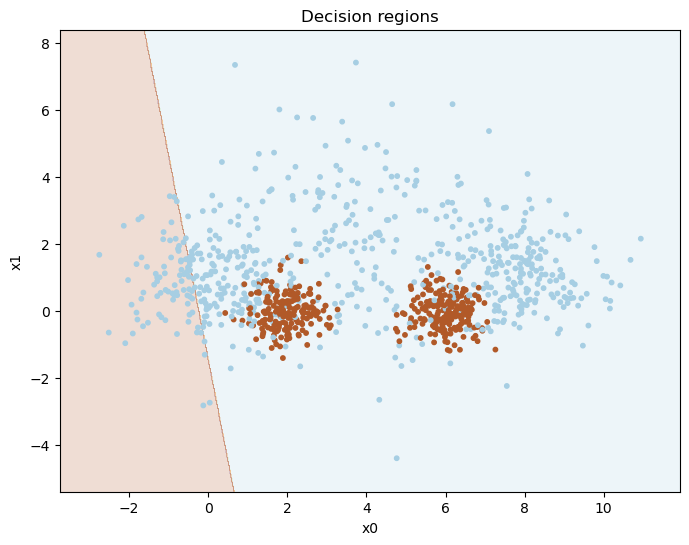

In [14]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.

### Answer: Tuning manually

Initial hyper-parameter values: eta = 0.1, epochs = 10, with an accuracy of 0.522.

#### With keeping epochs = 10, but changing eta:

The accuracy falls immediately upon increasing eta, but never goes below 0.516.
Putting eta = 0.01 yields an accuracy of 0.502, which is the worst so far.
Putting eta = 0.09 yields an accuracy of 0.55.
Putting eta = 0.08 yields an accuracy of 0.576.
Putting eta = 0.07 yields an accuracy of 0.532.
Every eta below 0.07 down to 0.01 is worste than 0.532.

#### With keeping eta = 0.08, but changing epochs:

It seems that the accuracy stays the same if the number of epochs is an even number, with an accuracy for 0.576.
The accuracy of epochs = 1 is 0.496. The accuracy of any odd number under 15 is worse than for the even numbers.
Epochs = 15 yields an accuracy of 0.574.
Epochs = 17 yields an accuracy of 0.596. It is now better than the initial value.
Epochs = 19 yields an accuracy of 0.606.
Epochs = 21 and epochs = 23 yields an accuracy of 0.624, after this it only gets worse.

#### With epochs = 21, try changing eta again:

Any other value than eta = 0.08 goes below 0.6.

#### Final values: eta = 0.08, epochs = 21, with an accuracy of 0.624

### The decision boundaries for the manually tuned classifier

In [15]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, eta=0.08, epochs=21)
accuracy(cl.predict(X_val), t2_val)

0.624

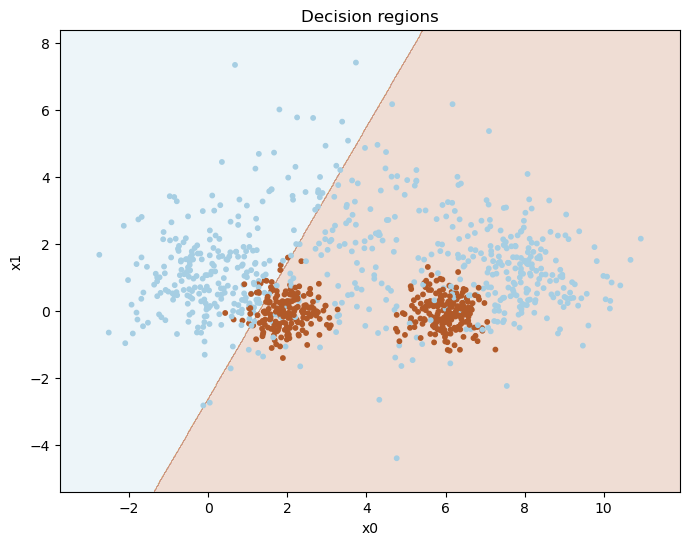

In [16]:
plot_decision_regions(X_train, t2_train, cl)

These decision regions are a lot better than the original one, but it is still higly incorrect. It would be best to tune the hyperparameters automatically.

### Answer: Tuning automatically with code inspired from solution to weekly exercises

In [17]:
## Tuning automatically
eta_start = 0.01
for epoch in [1, 2, 5, 10, 50, 100, 1000, 10000, 100000]:
    cl_tune = NumpyLinRegClass()
    cl_tune.fit(X_train, t2_train, eta=eta_start, epochs=epoch)
    print("Learning rate: {}  Epochs: {:7}  Accuracy: {}".format(
        eta_start, epoch, accuracy(cl_tune.predict(X_val), t2_val)))

Learning rate: 0.01  Epochs:       1  Accuracy: 0.576
Learning rate: 0.01  Epochs:       2  Accuracy: 0.576
Learning rate: 0.01  Epochs:       5  Accuracy: 0.574
Learning rate: 0.01  Epochs:      10  Accuracy: 0.502
Learning rate: 0.01  Epochs:      50  Accuracy: 0.504
Learning rate: 0.01  Epochs:     100  Accuracy: 0.56
Learning rate: 0.01  Epochs:    1000  Accuracy: 0.686
Learning rate: 0.01  Epochs:   10000  Accuracy: 0.704
Learning rate: 0.01  Epochs:  100000  Accuracy: 0.704


In [18]:
best_epochs = 10000
for eta in [0.01, 0.001, 0.0001, 0.00001]:
    cl_tune = NumpyLinRegClass()
    cl_tune.fit(X_train, t2_train, eta=eta, epochs=best_epochs)
    print("Learning rate: {:7}  Epochs: {:7}  Accuracy: {}".format(
        eta, best_epochs, accuracy(cl_tune.predict(X_val), t2_val)))

Learning rate:    0.01  Epochs:   10000  Accuracy: 0.704
Learning rate:   0.001  Epochs:   10000  Accuracy: 0.686
Learning rate:  0.0001  Epochs:   10000  Accuracy: 0.56
Learning rate:   1e-05  Epochs:   10000  Accuracy: 0.524


### Answer: tuning automatically

I first tuned with regards to the number of epochs, having the learning rate set as 0.01 and not 0.1 since it would cause overflows. The best accuracy of 0.704 came from a number of 10 000 epochs

Then after finding a good number of epochs, I tuned the learning rate with regards to this number of 10 000 epochs. The best accuracy of 0.704 came from a learning rate of 0.01

The decision regions from these parameters also makes the most sense when you look at the plot.

#### Final values: eta = 0.01, epochs = 10 000, with an accuracy of 0.704.

### The decision boundaries for the tuned classifier

In [19]:
cl_linreg = NumpyLinRegClass()
cl_linreg.fit(X_train, t2_train, eta=0.01, epochs=10000)
accuracy(cl_linreg.predict(X_val), t2_val)

0.704

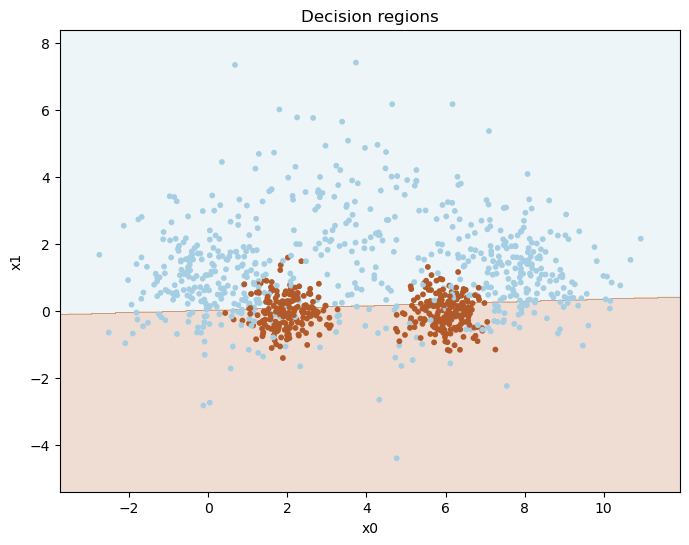

In [20]:
plot_decision_regions(X_train, t2_train, cl_linreg)

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

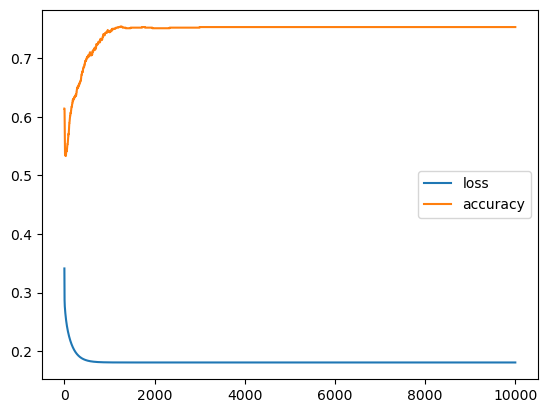

In [21]:
## Trains a classifier wit the best settings from last point.
cl_linreg2 = NumpyLinRegClass()
eta = 0.01
epochs = 10000
cl_linreg2.fit(X_train, t2_train, eta=eta, epochs=epochs)

## PLotting the loss and accuracy as a function of the number of epochs.
loss_list = cl_linreg2.loss
accuracy_list = cl_linreg2.accuracies
epochs_axis = range(0, epochs)

plt.plot(epochs_axis, loss_list, label="loss")
plt.plot(epochs_axis, accuracy_list, label="accuracy")
plt.legend()
plt.show()


### Answer:

The accuracy function appears to be monotone as expected, but it has a little bounce in the beginning that stabilizes at the top.

The loss function appears to be monotone, and decreasing, which is also expected.

### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

In [22]:
## Implementation of a max-min scaler.
def max_min_scaler(training_data):
    
    len_j = training_data.shape[0]
    len_i = training_data.shape[1]
    result = training_data.copy()
    
    for i in range(len_i):
        # All observations, but only feature i.
        min_i = min(training_data[:, i])
        max_i = max(training_data[:, i]) 
        
        # Scaling the data.
        for j in range(len_j):
            xji = training_data[j, i]
            scaled_xji = (xji - min_i) / (max_i - min_i)
            result[j][i] = scaled_xji
            
    return result

X_train_scaled = max_min_scaler(X_train)
X_val_scaled = max_min_scaler(X_val)

In [23]:
# Experimenting with new hyper-parameters to be used with scaled data.
eta_start = 1
for epoch in [1, 2, 5, 10, 50, 100, 1000, 10000, 100000]:
    cl_tune = NumpyLinRegClass()
    cl_tune.fit(X_train_scaled, t2_train, eta=eta_start, epochs=epoch)
    print("Learning rate: {}  Epochs: {:7}  Accuracy: {}".format(
        eta_start, epoch, accuracy(cl_tune.predict(X_val_scaled), t2_val)))

Learning rate: 1  Epochs:       1  Accuracy: 0.432
Learning rate: 1  Epochs:       2  Accuracy: 0.576
Learning rate: 1  Epochs:       5  Accuracy: 0.576
Learning rate: 1  Epochs:      10  Accuracy: 0.576
Learning rate: 1  Epochs:      50  Accuracy: 0.77
Learning rate: 1  Epochs:     100  Accuracy: 0.742
Learning rate: 1  Epochs:    1000  Accuracy: 0.69
Learning rate: 1  Epochs:   10000  Accuracy: 0.69
Learning rate: 1  Epochs:  100000  Accuracy: 0.69


In [24]:
best_epochs = 100
for eta in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    cl_tune = NumpyLinRegClass()
    cl_tune.fit(X_train_scaled, t2_train, eta=eta, epochs=best_epochs)
    print("Learning rate: {:7}  Epochs: {:7}  Accuracy: {}".format(
        eta, best_epochs, accuracy(cl_tune.predict(X_val_scaled), t2_val)))

Learning rate:       1  Epochs:     100  Accuracy: 0.742
Learning rate:     0.1  Epochs:     100  Accuracy: 0.576
Learning rate:    0.01  Epochs:     100  Accuracy: 0.576
Learning rate:   0.001  Epochs:     100  Accuracy: 0.576
Learning rate:  0.0001  Epochs:     100  Accuracy: 0.576
Learning rate:   1e-05  Epochs:     100  Accuracy: 0.576


### Results from tuning hyperparameter with scaled sets

It appears that the learning rate can have a value of 1 without causing an overflow, and that this also speeds up the training hundredfold, achieving an even better accuracy than before aswell. An eta of 10 will cause an overflow, which would not work in this case, just like an eta of 0.1 for the unscaled set.

#### Final hyperparameter values: eta = 1, epochs = 100, with an accuracy of 0.742

### Training the model with these parameters and plotting the decision regions

In [25]:
# Trains the model on the scaled data.
cl_linreg3 = NumpyLinRegClass()
eta = 1
epochs = 100
cl_linreg3.fit(X_train_scaled, t2_train, eta=eta, epochs=epochs)

# Checks the accuracy on the scaled validation set
X_val_scaled = max_min_scaler(X_val)
accuracy(cl_linreg3.predict(X_val_scaled), t2_val)


0.742

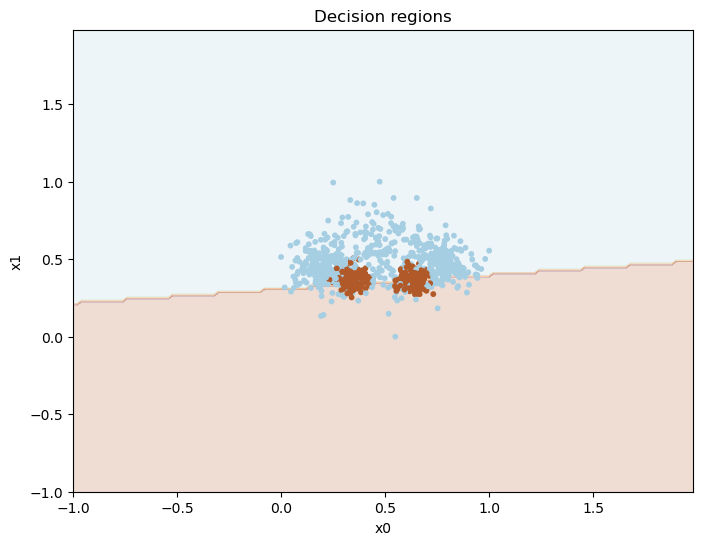

In [26]:
plot_decision_regions(X_train_scaled, t2_train, cl_linreg3)

An experimental value I found outside of these automatically generated parameters is 0.77.
This can be reached with eta = 0.001, and 50 000 epochs.

### Plotting loss and accuracy as a function of the number of epochs

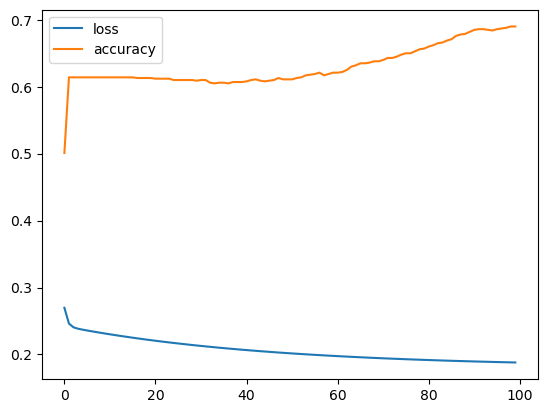

In [27]:
## PLotting the loss and accuracy as a function of the number of epochs.
loss_list = cl_linreg3.loss
accuracy_list = cl_linreg3.accuracies
epochs_axis = range(0, epochs)

plt.plot(epochs_axis, loss_list, label="loss")
plt.plot(epochs_axis, accuracy_list, label="accuracy")
plt.legend()
plt.show()

## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

### Implementing the logistic regression classifier using code from solutions to weekly exercises
Implementation using MSE

In [28]:
## a) Implementing the logistic regression classifier. Code taken from solution to weekly exercise set week07

def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyLogReg(NumpyClassifier):
    
    def __init__(self, bias=-1):
        self.bias=bias

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, X_val=[], t_val=[], tol=5, n_epochs_no_update=5):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        X_train_old = X_train
        X_val_old = X_val
        
        val_check = 0
        if (len(X_val) != 0 and len(t_val) != 0):
            val_check = 1
            if self.bias:
                X_val = add_bias(X_val, self.bias)
        
        (N, m) = X_train.shape
        if self.bias:
            X_train = add_bias(X_train, self.bias)
        
        self.weights = weights = np.zeros(m+1)
        
        # Stores loss and accuracy data.
        self.loss_train = []
        self.loss_val = []
        self.accuracies_train = []
        self.accuracies_val = []
        
        # Used to control the tolerance of the training.
        self.number_of_epochs = 0
        current_n_epochs_no_update = 0
        current_asserted_value = 9999999
        
        for e in range(epochs):
            weights -= eta / N *  X_train.T @ (self.forward(X_train) - t_train)
            
            # Loss and accuracy for training sets.
            error = t_train - self.forward(X_train)
            MSE_train = (1 / N) * (error.T @ error)
            self.loss_train.append(MSE_train)
            self.accuracies_train.append(accuracy(self.predict(X_train_old), t_train))
            
            self.number_of_epochs += 1
            
            # Loss and accuracy for validation sets if given.
            if (val_check):
                error = t_val - self.forward(X_val)
                MSE_val = (1 / N) * (error.T @ error)
                self.loss_val.append(MSE_val)
                self.accuracies_val.append(accuracy(self.predict(X_val_old), t_val))
            
                # Checks the tolerance for the training.
                if ((current_asserted_value - MSE_val) > tol):
                    current_n_epochs_no_update = 0
                    current_asserted_value = MSE_val
                else:
                    current_n_epochs_no_update += 1

                if (current_n_epochs_no_update == n_epochs_no_update):
                    #pass
                    break
            
    
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            z = add_bias(X, self.bias)
        return (self.forward(z) > threshold).astype('int')
    
    def predict_probability(self, X):
        if self.bias:
            z = add_bias(X, self.bias)
        return self.forward(z)
    
    # Does not add bias term. NOT USED
    def cross_entropy_loss(self, X, t):
        sum = 0
        N = t.shape[0]
        probabilities = np.zeros(N)
        
        for j in range(0, N):
            xj = X[j]
            wj = self.weights[j]
            yj = self.logistic(x @ w)
            tj = t[j]
            probability = (y**tj) * ((1 - yj)**(1 - tj))
            probabilities[j] = probability
        
        for j in range(0, N):
            Xj = X[j]
            tj = t[j]
            probability = probabilities[j]
            logarithm = np.log(probability)
            sum -= logarithm
            
        return sum
            

### Training various classifiers without scaling

I have decided to use a total number of epochs = 100 000, a starting learning rate of 0.1, and 10 epochs without any updates.

In [29]:
epochs = 100000
eta_start = 0.1

for tol in [5, 0.5, 0.05, 0.005, 0.0005, 0.00005, 0.000005]:
    cl_tune = NumpyLogReg()
    cl_tune.fit(X_train, t2_train, eta=eta_start, epochs=epochs, X_val=X_val, t_val = t2_val, tol=tol, n_epochs_no_update = 10)
    print("Learning rate: {:7}  tol: {:7}  Accuracy: {}  No_epochs: {}".format(
        eta_start, tol, accuracy(cl_tune.predict(X_val), t2_val), cl_tune.number_of_epochs))

Learning rate:     0.1  tol:       5  Accuracy: 0.604  No_epochs: 11
Learning rate:     0.1  tol:     0.5  Accuracy: 0.604  No_epochs: 11
Learning rate:     0.1  tol:    0.05  Accuracy: 0.604  No_epochs: 11
Learning rate:     0.1  tol:   0.005  Accuracy: 0.668  No_epochs: 32
Learning rate:     0.1  tol:  0.0005  Accuracy: 0.69  No_epochs: 80
Learning rate:     0.1  tol:   5e-05  Accuracy: 0.704  No_epochs: 195
Learning rate:     0.1  tol:   5e-06  Accuracy: 0.71  No_epochs: 589


In [30]:
best_tol = 0.000005

for eta in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    cl_tune = NumpyLogReg()
    cl_tune.fit(X_train, t2_train, eta=eta, epochs=epochs, X_val=X_val, t_val = t2_val, tol=best_tol, n_epochs_no_update = 10)
    print("Learning rate: {:7}  tol: {:7}  Accuracy: {}  No_epochs: {}".format(
        eta, best_tol, accuracy(cl_tune.predict(X_val), t2_val), cl_tune.number_of_epochs))

Learning rate:       1  tol:   5e-06  Accuracy: 0.684  No_epochs: 14
Learning rate:     0.1  tol:   5e-06  Accuracy: 0.71  No_epochs: 589
Learning rate:    0.01  tol:   5e-06  Accuracy: 0.704  No_epochs: 1829
Learning rate:   0.001  tol:   5e-06  Accuracy: 0.684  No_epochs: 6710
Learning rate:  0.0001  tol:   5e-06  Accuracy: 0.642  No_epochs: 19178
Learning rate:   1e-05  tol:   5e-06  Accuracy: 0.544  No_epochs: 4353


### Results from training without scaling:

With a tolerance of 5e-06 and learning rate of 0.1, the classifier has achieved an accuracy of 0.71.


### Training various classifiers with scaling

In [31]:
epochs = 100000
eta_start = 1

for tol in [5, 0.5, 0.05, 0.005, 0.0005, 0.00005, 0.000005]:
    cl_tune = NumpyLogReg()
    cl_tune.fit(X_train_scaled, t2_train, eta=eta_start, epochs=epochs, X_val=X_val_scaled, t_val = t2_val, tol=tol, n_epochs_no_update = 10)
    print("Learning rate: {:7}  tol: {:7}  Accuracy: {}  No_epochs: {}".format(
        eta_start, tol, accuracy(cl_tune.predict(X_val_scaled), t2_val), cl_tune.number_of_epochs))

Learning rate:       1  tol:       5  Accuracy: 0.576  No_epochs: 11
Learning rate:       1  tol:     0.5  Accuracy: 0.576  No_epochs: 11
Learning rate:       1  tol:    0.05  Accuracy: 0.576  No_epochs: 11
Learning rate:       1  tol:   0.005  Accuracy: 0.576  No_epochs: 11
Learning rate:       1  tol:  0.0005  Accuracy: 0.786  No_epochs: 178
Learning rate:       1  tol:   5e-05  Accuracy: 0.752  No_epochs: 309
Learning rate:       1  tol:   5e-06  Accuracy: 0.75  No_epochs: 336


In [32]:
best_tol_scaled = 0.0005

for eta in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    cl_tune = NumpyLogReg()
    cl_tune.fit(X_train_scaled, t2_train, eta=eta, epochs=epochs, X_val=X_val_scaled, t_val = t2_val, tol=best_tol_scaled, n_epochs_no_update = 10)
    print("Learning rate: {:7}  tol: {:7}  Accuracy: {}  No_epochs: {}".format(
        eta, best_tol_scaled, accuracy(cl_tune.predict(X_val_scaled), t2_val), cl_tune.number_of_epochs))

Learning rate:       1  tol:  0.0005  Accuracy: 0.786  No_epochs: 178
Learning rate:     0.1  tol:  0.0005  Accuracy: 0.576  No_epochs: 40
Learning rate:    0.01  tol:  0.0005  Accuracy: 0.576  No_epochs: 11
Learning rate:   0.001  tol:  0.0005  Accuracy: 0.576  No_epochs: 11
Learning rate:  0.0001  tol:  0.0005  Accuracy: 0.576  No_epochs: 11
Learning rate:   1e-05  tol:  0.0005  Accuracy: 0.576  No_epochs: 11


### Results from training with scaling:

With a tolerance of 5e-04 and learning rate of 1, the classifier has achieved an accuracy of 0.786. This is the all time best.

#### Final values: eta = 1, tolerance = 05e-04, epochs = 100 000, n_epochs_no_update = 10, SCALED SETS.

### Plotting the results from scaled training with these final values

In [33]:
#
eta = 1
tol = 0.0005
epochs = 100000

cl_logreg = NumpyLogReg()
cl_logreg.fit(X_train_scaled, t2_train, eta=eta, epochs=epochs, 
                   X_val=X_val_scaled, t_val = t2_val, tol=tol, n_epochs_no_update = 10)



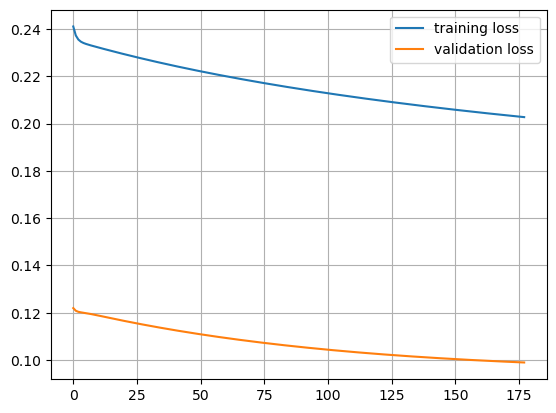

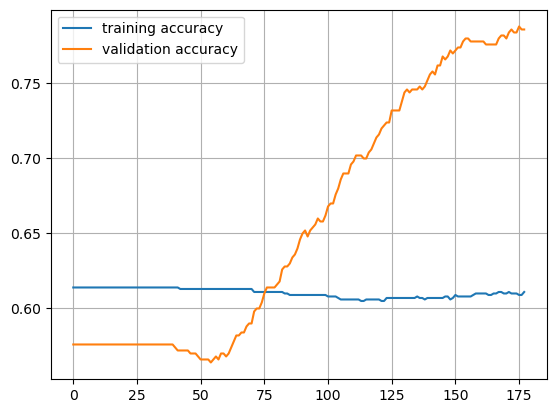

In [34]:
loss_train_list = cl_logreg.loss_train
loss_val_list = cl_logreg.loss_val

accuracies_train_list = cl_logreg.accuracies_train
accuracies_val_list = cl_logreg.accuracies_val

epochs_axis = range(cl_logreg.number_of_epochs)

plt.plot(epochs_axis, loss_train_list, label="training loss")
plt.plot(epochs_axis, loss_val_list, label="validation loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs_axis, accuracies_train_list, label="training accuracy")
plt.plot(epochs_axis, accuracies_val_list, label="validation accuracy")
plt.legend()
plt.grid()
plt.show()


It appears that with the results from training with scaled sets, the loss curves seem monotone. The validation loss also appears to be half of the training loss. As for the accuracy, the training accuracy stays the same, but the validation accuracy increases by a large amount.

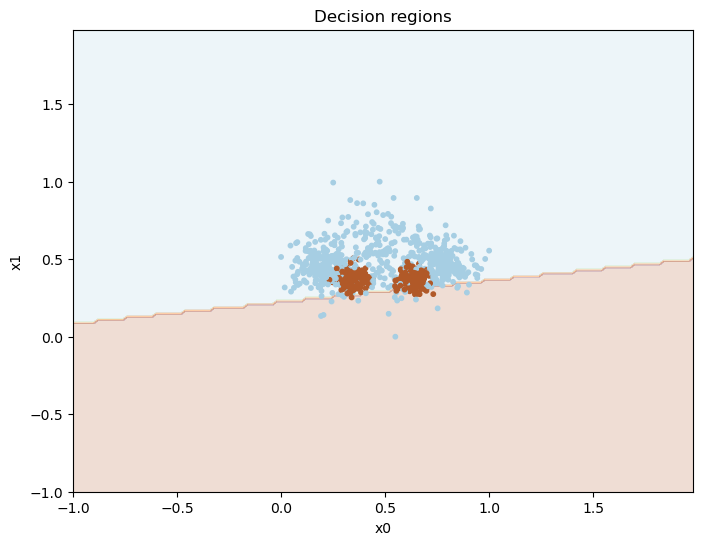

In [35]:
plot_decision_regions(X_train_scaled, t2_train, cl_logreg)

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [36]:
class OneVsRest(NumpyClassifier):
        
    def fit(self, X_train, t_multi_train, eta = 0.01, epochs=100000, X_val=[], t_multi_val=[], tol=0.000005, n_epochs_no_update=10):
        self.classifiers = []
        
        for decision in range(0, 5):
            # Makes the training sets binary.
            t_train_inner = self.split_training_set(t_multi_train, decision)
            t_val_inner = self.split_training_set(t_multi_val, decision)
            
            # Trains a binary logistic regression classifier on the binary sets.
            cl_logi_inner = NumpyLogReg()
            cl_logi_inner.fit(X_train, t_train_inner, eta=eta, epochs=epochs, 
                              X_val=X_val, t_val=t_val_inner, tol=tol, n_epochs_no_update=n_epochs_no_update)
            
            # Appends the weights to the total list of weights.
            self.classifiers.append(cl_logi_inner)
    
    def split_training_set(self, t_multi_train, decision):
        t2_train = t_multi_train == decision
        t2_train = t2_train.astype('int')
        return t2_train
    
    def predict(self, X):
        
        list_of_probabilities_list = []
        
        for i in range(0, 5):
            list_of_probabilities = self.classifiers[i].predict_probability(X)
            list_of_probabilities_list.append(list_of_probabilities)
        
        len_X = X.shape[0]
        resulting_y = np.zeros(len_X)
        
        for j in range(0, len_X):
            observation_x = X[j]
            
            highest_probability = 0
            highest_probability_index = 0  # important
            
            for i in range(0, 5):
                list_of_probabilities = list_of_probabilities_list[i]
                if list_of_probabilities[j] > highest_probability:
                    highest_probability = list_of_probabilities[j]
                    highest_probability_index = i
            
            # Use the highest_probability_index to decide X[j]
            resulting_y[j] = highest_probability_index
        
        return resulting_y
            

### Tuning the hyperparameters for One vs Rest without scaling

In [37]:
epochs = 100000
eta_start = 0.1

for tol in [5, 0.5, 0.05, 0.005, 0.0005, 0.00005, 0.000005]:
    cl_tune = OneVsRest()
    cl_tune.fit(X_train, t_multi_train, eta=eta_start, epochs=epochs, 
                X_val=X_val, t_multi_val=t_multi_val, tol=tol, n_epochs_no_update = 10)
    print("Learning rate: {:7}  tol: {:7}  Accuracy: {}".format(
        eta_start, tol, accuracy(cl_tune.predict(X_val), t_multi_val)))

Learning rate:     0.1  tol:       5  Accuracy: 0.356
Learning rate:     0.1  tol:     0.5  Accuracy: 0.356
Learning rate:     0.1  tol:    0.05  Accuracy: 0.356
Learning rate:     0.1  tol:   0.005  Accuracy: 0.422
Learning rate:     0.1  tol:  0.0005  Accuracy: 0.686
Learning rate:     0.1  tol:   5e-05  Accuracy: 0.788
Learning rate:     0.1  tol:   5e-06  Accuracy: 0.822


In [38]:
best_tol = 0.000005

for eta in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    cl_tune = OneVsRest()
    cl_tune.fit(X_train, t_multi_train, eta=eta, epochs=epochs, 
                X_val=X_val, t_multi_val=t_multi_val, tol=best_tol, n_epochs_no_update = 10)
    print("Learning rate: {:7}  tol: {:7}  Accuracy: {}".format(
        eta, best_tol, accuracy(cl_tune.predict(X_val), t_multi_val)))

Learning rate:       1  tol:   5e-06  Accuracy: 0.426
Learning rate:     0.1  tol:   5e-06  Accuracy: 0.822
Learning rate:    0.01  tol:   5e-06  Accuracy: 0.788
Learning rate:   0.001  tol:   5e-06  Accuracy: 0.682
Learning rate:  0.0001  tol:   5e-06  Accuracy: 0.378
Learning rate:   1e-05  tol:   5e-06  Accuracy: 0.264


### Results from the training without scaling:

With a tolerance of 5e-06 and learning rate of 0.1, we can achieve the accuracy of 0.822 with multi-class classifying, without scaling.

### Tuning the hyperparameters for One vs Rest with scaling

In [39]:
epochs = 100000
eta_start = 1

for tol in [5, 0.5, 0.05, 0.005, 0.0005, 0.00005, 0.000005, 0.0000005, 0.00000005]:
    cl_tune = OneVsRest()
    cl_tune.fit(X_train_scaled, t_multi_train, eta=eta_start, epochs=epochs, 
                X_val=X_val_scaled, t_multi_val=t_multi_val, tol=tol, n_epochs_no_update = 10)
    print("Learning rate: {:7}  tol: {:7}  Accuracy: {}".format(
        eta_start, tol, accuracy(cl_tune.predict(X_val_scaled), t_multi_val)))

Learning rate:       1  tol:       5  Accuracy: 0.418
Learning rate:       1  tol:     0.5  Accuracy: 0.418
Learning rate:       1  tol:    0.05  Accuracy: 0.418
Learning rate:       1  tol:   0.005  Accuracy: 0.414
Learning rate:       1  tol:  0.0005  Accuracy: 0.64
Learning rate:       1  tol:   5e-05  Accuracy: 0.818
Learning rate:       1  tol:   5e-06  Accuracy: 0.822
Learning rate:       1  tol:   5e-07  Accuracy: 0.832
Learning rate:       1  tol:   5e-08  Accuracy: 0.832


In [40]:
best_tol_scaled = 0.0000005

for eta in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    cl_tune = OneVsRest()
    cl_tune.fit(X_train_scaled, t_multi_train, eta=eta, epochs=epochs, 
                X_val=X_val_scaled, t_multi_val=t_multi_val, tol=best_tol_scaled, n_epochs_no_update = 10)
    print("Learning rate: {:7}  tol: {:7}  Accuracy: {}".format(
        eta, best_tol_scaled, accuracy(cl_tune.predict(X_val_scaled), t_multi_val)))

Learning rate:       1  tol:   5e-07  Accuracy: 0.832
Learning rate:     0.1  tol:   5e-07  Accuracy: 0.822
Learning rate:    0.01  tol:   5e-07  Accuracy: 0.818
Learning rate:   0.001  tol:   5e-07  Accuracy: 0.62
Learning rate:  0.0001  tol:   5e-07  Accuracy: 0.592
Learning rate:   1e-05  tol:   5e-07  Accuracy: 0.4


### Results from the training with scaling only:

With a tolerance of 5e-07 and learning rate of 1, we can achieve the accuracy of 0.832 with multi-class classifying, with scaling.

### Plotting the decision boundaries on both unscaled and scaled

In [41]:
eta = 0.1
eta_scaled = 1
tol = 0.000005
tol_scaled = 0.0000005
epochs = 100000


cl_multi_unscaled = OneVsRest()
cl_multi_unscaled.fit(X_train, t_multi_train, eta=eta, epochs=epochs, 
             X_val=X_val, t_multi_val=t_multi_val, tol=tol, n_epochs_no_update = 10)


cl_multi_scaled = OneVsRest()
cl_multi_scaled.fit(X_train_scaled, t_multi_train, eta=eta_scaled, epochs=epochs, 
             X_val=X_val_scaled, t_multi_val=t_multi_val, tol=tol_scaled, n_epochs_no_update = 10)


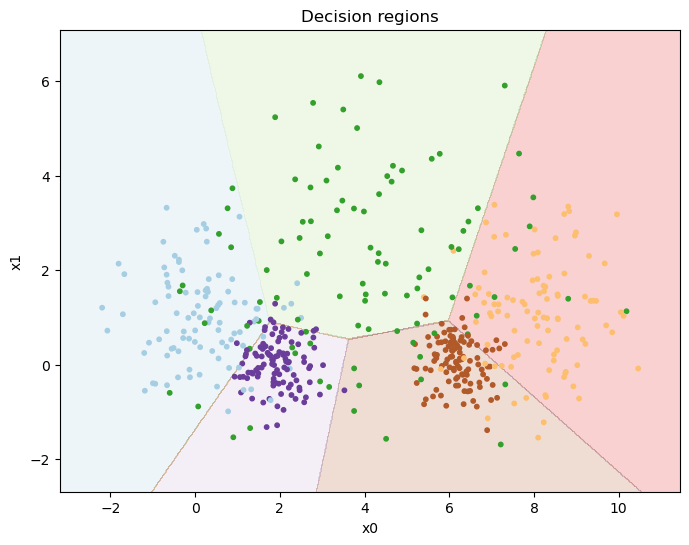

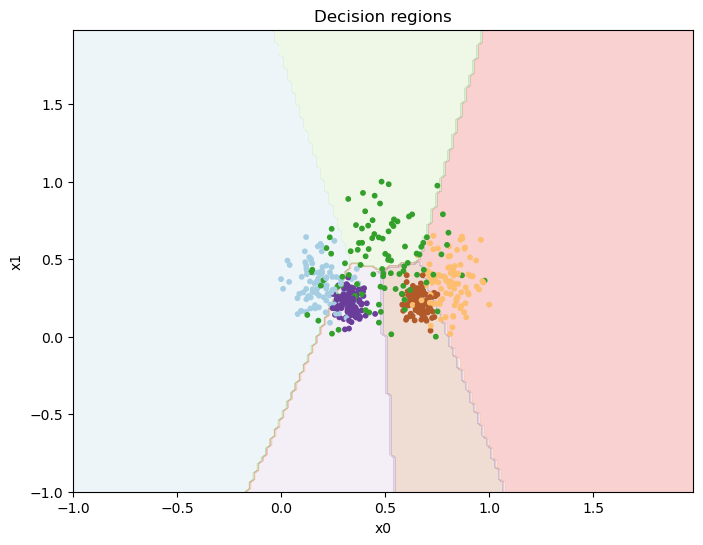

In [42]:
plot_decision_regions(X_val, t_multi_val, cl_multi_unscaled)
plot_decision_regions(X_val_scaled, t_multi_val, cl_multi_scaled)

The resulting decision boundaries seem highly accurate!

### For in4050-students: Multi-nominal logistic regression
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. 

Remember that this classifier uses softmax in the forward phase. For loss, it uses categorical cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [43]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, eta=0.001, epochs = 100, X_val=[], t_val=[], tol=0.5, n_epochs_no_update=10):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        """
        # This time, no bias will be added. Code written by myself
        val_check = 0
        X_val_bias = 0
        T_val = 0
        if (len(X_val) != 0 and len(t_val) != 0):
            val_check = 1
            X_val_bias = add_bias(X_val, self.bias)
            T_val = t_val.reshape(-1,1)
        
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
        
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Stores loss and accuracy data. Code written by myself
        self.loss_train = []
        self.loss_val = []
        self.accuracies_train = []
        self.accuracies_val = []
        
        # Used to control the tolerance of the training. Code written by myself
        self.number_of_epochs = 0
        current_n_epochs_no_update = 0
        current_asserted_value = 9999999
        
        
        # Itilaize the wights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        
        for e in range(epochs):
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                self.activ_diff(hidden_outs[:, 1:]))  
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights
            
            
            # Calculates loss and accuracy. Code written by myself
            SE_train = out_deltas.T @ out_deltas
            SE_train = SE_train.reshape(-1)
            #print(SE_train.reshape)
            self.loss_train.append(SE_train)
            self.accuracies_train.append(accuracy(self.predict(X_train), t_train))
            
            self.number_of_epochs += 1
            
            # Loss and accuracy for validation sets if given. Code written by myself
            if (val_check):
                _, val_outputs = self.forward(X_val_bias)
                val_out_deltas = (val_outputs - T_val)
                SE_val = val_out_deltas.T @ val_out_deltas
                SE_val = SE_val.reshape(-1)
                self.loss_val.append(SE_val)
                self.accuracies_val.append(accuracy(self.predict(X_val), t_val))
            
                # Checks the tolerance for the training. Code written by myself
                #print(f"{current_asserted_value - MSE_train}")
                if ((current_asserted_value - SE_val) > tol):
                    #print("Tolerance broken!!!")
                    current_n_epochs_no_update = 0
                    current_asserted_value = SE_val
                else:
                    current_n_epochs_no_update += 1

                if (current_n_epochs_no_update == n_epochs_no_update):
                    #pass
                    break
            
            
            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)
    
    # Code inspired by the forward function and predict function.
    # It uses sigmoid function for the last layer of outputs to generate probabilities.
    def predict_probability(self, X):
        Z = add_bias(X, self.bias)
        hidden_activations = self.activ(Z @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = self.activ(hidden_outs @ self.weights2)
        probabilites = output[:, 0]
        return probabilites


## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

### Tuning the parameters without scaling

For this classifier, I've chosen n_epochs_no_update = 100.

In [44]:
epochs = 100000
eta_start = 0.001
dim_hidden_start = 6

for tol in [500, 50, 5, 0.5, 0.05, 0.005, 0.0005, 0.00005]:
    cl_tune = MLPBinaryLinRegClass(dim_hidden=dim_hidden_start)
    cl_tune.fit(X_train, t2_train, eta=eta_start, epochs=epochs, 
                X_val=X_val, t_val=t2_val, tol=tol, n_epochs_no_update = 100)
    print("Learning rate: {:7}  tol: {:7}  dim_hidden: {:3}  Accuracy: {} no_epochs: {}".format(
        eta_start, tol, dim_hidden_start, accuracy(cl_tune.predict(X_val_scaled), t2_val), cl_tune.number_of_epochs))


Learning rate:   0.001  tol:     500  dim_hidden:   6  Accuracy: 0.576 no_epochs: 125
Learning rate:   0.001  tol:      50  dim_hidden:   6  Accuracy: 0.556 no_epochs: 127
Learning rate:   0.001  tol:       5  dim_hidden:   6  Accuracy: 0.55 no_epochs: 189
Learning rate:   0.001  tol:     0.5  dim_hidden:   6  Accuracy: 0.59 no_epochs: 209
Learning rate:   0.001  tol:    0.05  dim_hidden:   6  Accuracy: 0.532 no_epochs: 314
Learning rate:   0.001  tol:   0.005  dim_hidden:   6  Accuracy: 0.572 no_epochs: 185
Learning rate:   0.001  tol:  0.0005  dim_hidden:   6  Accuracy: 0.618 no_epochs: 267
Learning rate:   0.001  tol:   5e-05  dim_hidden:   6  Accuracy: 0.546 no_epochs: 290


In [45]:
best_tol = 0.5

for eta in [0.0001, 0.00001, 0.000001, 0.0000001]:
    cl_tune = MLPBinaryLinRegClass(dim_hidden=dim_hidden_start)
    cl_tune.fit(X_train, t2_train, eta=eta, epochs=epochs, 
                X_val=X_val, t_val=t2_val, tol=best_tol, n_epochs_no_update = 100)
    print("Learning rate: {:7}  tol: {:4}  dim_hidden: {:3}  Accuracy: {} no_epochs: {}".format(
        eta, best_tol, dim_hidden_start, accuracy(cl_tune.predict(X_val), t2_val), cl_tune.number_of_epochs))

Learning rate:  0.0001  tol:  0.5  dim_hidden:   6  Accuracy: 0.828 no_epochs: 1333
Learning rate:   1e-05  tol:  0.5  dim_hidden:   6  Accuracy: 0.764 no_epochs: 2009
Learning rate:   1e-06  tol:  0.5  dim_hidden:   6  Accuracy: 0.576 no_epochs: 4157
Learning rate:   1e-07  tol:  0.5  dim_hidden:   6  Accuracy: 0.574 no_epochs: 4945


In [46]:
best_eta = 0.0001

for dim_hidden in range(6, 100, 6):
    cl_tune = MLPBinaryLinRegClass(dim_hidden=dim_hidden)
    cl_tune.fit(X_train, t2_train, eta=best_eta, epochs=epochs, 
                X_val=X_val, t_val=t2_val, tol=best_tol, n_epochs_no_update = 100)
    print("Learning rate: {:7}  tol: {:4}  dim_hidden: {:3}  Accuracy: {} no_epochs: {}".format(
        eta, best_tol, dim_hidden, accuracy(cl_tune.predict(X_val), t2_val), cl_tune.number_of_epochs))

Learning rate:   1e-07  tol:  0.5  dim_hidden:   6  Accuracy: 0.832 no_epochs: 1688
Learning rate:   1e-07  tol:  0.5  dim_hidden:  12  Accuracy: 0.826 no_epochs: 1048
Learning rate:   1e-07  tol:  0.5  dim_hidden:  18  Accuracy: 0.824 no_epochs: 1380
Learning rate:   1e-07  tol:  0.5  dim_hidden:  24  Accuracy: 0.826 no_epochs: 1156
Learning rate:   1e-07  tol:  0.5  dim_hidden:  30  Accuracy: 0.844 no_epochs: 1087
Learning rate:   1e-07  tol:  0.5  dim_hidden:  36  Accuracy: 0.832 no_epochs: 847
Learning rate:   1e-07  tol:  0.5  dim_hidden:  42  Accuracy: 0.834 no_epochs: 846
Learning rate:   1e-07  tol:  0.5  dim_hidden:  48  Accuracy: 0.836 no_epochs: 1156
Learning rate:   1e-07  tol:  0.5  dim_hidden:  54  Accuracy: 0.854 no_epochs: 792
Learning rate:   1e-07  tol:  0.5  dim_hidden:  60  Accuracy: 0.852 no_epochs: 731
Learning rate:   1e-07  tol:  0.5  dim_hidden:  66  Accuracy: 0.854 no_epochs: 705
Learning rate:   1e-07  tol:  0.5  dim_hidden:  72  Accuracy: 0.854 no_epochs: 85

### Results from tuning without scaling

It seems that with tolerance, it does not matter much, and I therefore chose 0.5 as a good middleground. For the learning rate, it seems that higher values dominate, and i chose eta = 0.0001. Also, eta as little as 0.001 causes overflow. For dim_hidden the accuracy seems to generally max out around dim_hidden = 36.

### Tuning the hyperparameters with scaling

In [47]:
epochs = 100000
eta_start = 0.001
dim_hidden_start = 6

for tol in [500, 50, 5, 0.5, 0.05, 0.005, 0.0005, 0.00005, 0.000005]:
    cl_tune = MLPBinaryLinRegClass(dim_hidden=dim_hidden_start)
    cl_tune.fit(X_train_scaled, t2_train, eta=eta_start, epochs=epochs, 
                X_val=X_val_scaled, t_val=t2_val, tol=tol, n_epochs_no_update = 100)
    print("Learning rate: {:7}  tol: {:7}  dim_hidden: {:3}  Accuracy: {} no_epochs: {}".format(
        eta_start, tol, dim_hidden_start, accuracy(cl_tune.predict(X_val_scaled), t2_val), cl_tune.number_of_epochs))

Learning rate:   0.001  tol:     500  dim_hidden:   6  Accuracy: 0.576 no_epochs: 101
Learning rate:   0.001  tol:      50  dim_hidden:   6  Accuracy: 0.564 no_epochs: 107
Learning rate:   0.001  tol:       5  dim_hidden:   6  Accuracy: 0.756 no_epochs: 391
Learning rate:   0.001  tol:     0.5  dim_hidden:   6  Accuracy: 0.726 no_epochs: 555
Learning rate:   0.001  tol:    0.05  dim_hidden:   6  Accuracy: 0.722 no_epochs: 394
Learning rate:   0.001  tol:   0.005  dim_hidden:   6  Accuracy: 0.72 no_epochs: 442
Learning rate:   0.001  tol:  0.0005  dim_hidden:   6  Accuracy: 0.718 no_epochs: 465
Learning rate:   0.001  tol:   5e-05  dim_hidden:   6  Accuracy: 0.718 no_epochs: 421
Learning rate:   0.001  tol:   5e-06  dim_hidden:   6  Accuracy: 0.718 no_epochs: 401


In [48]:
best_tol = 0.05

for eta in [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]:
    cl_tune = MLPBinaryLinRegClass(dim_hidden=dim_hidden_start)
    cl_tune.fit(X_train_scaled, t2_train, eta=eta, epochs=epochs, 
                X_val=X_val_scaled, t_val=t2_val, tol=best_tol, n_epochs_no_update = 100)
    print("Learning rate: {:7}  tol: {:4}  dim_hidden: {:3}  Accuracy: {} no_epochs: {}".format(
        eta, best_tol, dim_hidden_start, accuracy(cl_tune.predict(X_val_scaled), t2_val), cl_tune.number_of_epochs))

Learning rate:   0.001  tol: 0.05  dim_hidden:   6  Accuracy: 0.718 no_epochs: 470
Learning rate:  0.0001  tol: 0.05  dim_hidden:   6  Accuracy: 0.762 no_epochs: 2336
Learning rate:   1e-05  tol: 0.05  dim_hidden:   6  Accuracy: 0.768 no_epochs: 23586
Learning rate:   1e-06  tol: 0.05  dim_hidden:   6  Accuracy: 0.576 no_epochs: 2121
Learning rate:   1e-07  tol: 0.05  dim_hidden:   6  Accuracy: 0.576 no_epochs: 4583


In [50]:
best_eta = 0.00001

for dim_hidden in range(6, 100, 6):
    cl_tune = MLPBinaryLinRegClass(dim_hidden=dim_hidden)
    cl_tune.fit(X_train_scaled, t2_train, eta=best_eta, epochs=epochs, 
                X_val=X_val_scaled, t_val=t2_val, tol=best_tol, n_epochs_no_update = 100)
    print("Learning rate: {:7}  tol: {:4}  dim_hidden: {:3}  Accuracy: {} no_epochs: {}".format(
        best_eta, best_tol, dim_hidden, accuracy(cl_tune.predict(X_val_scaled), t2_val), cl_tune.number_of_epochs))

Learning rate:   1e-05  tol: 0.05  dim_hidden:   6  Accuracy: 0.774 no_epochs: 36455
Learning rate:   1e-05  tol: 0.05  dim_hidden:  12  Accuracy: 0.576 no_epochs: 129
Learning rate:   1e-05  tol: 0.05  dim_hidden:  18  Accuracy: 0.764 no_epochs: 18436
Learning rate:   1e-05  tol: 0.05  dim_hidden:  24  Accuracy: 0.764 no_epochs: 17455
Learning rate:   1e-05  tol: 0.05  dim_hidden:  30  Accuracy: 0.764 no_epochs: 10636
Learning rate:   1e-05  tol: 0.05  dim_hidden:  36  Accuracy: 0.762 no_epochs: 12532
Learning rate:   1e-05  tol: 0.05  dim_hidden:  42  Accuracy: 0.772 no_epochs: 11308
Learning rate:   1e-05  tol: 0.05  dim_hidden:  48  Accuracy: 0.776 no_epochs: 8335
Learning rate:   1e-05  tol: 0.05  dim_hidden:  54  Accuracy: 0.756 no_epochs: 10684
Learning rate:   1e-05  tol: 0.05  dim_hidden:  60  Accuracy: 0.758 no_epochs: 8542
Learning rate:   1e-05  tol: 0.05  dim_hidden:  66  Accuracy: 0.752 no_epochs: 6507
Learning rate:   1e-05  tol: 0.05  dim_hidden:  72  Accuracy: 0.758 no

### Results from tuning with scaling

It seems that with tolerance, it seems to favour values under 0.5, and I therefore chose tol = 0.05. For the learning rate, it seems that eta = 0.00001 is generally the best. For dim_hidden the accuracy seems to again generally max out around dim_hidden = 36.

The scaling ends up being worse with this classifier.

### Training with tuned hyperparameters for unscaled sets, and plotting loss and accuracy

In [51]:
epochs = 100000
eta = 0.0001
tol = 0.5
dim_hidden = 36

cl_mlp = MLPBinaryLinRegClass(dim_hidden=dim_hidden)
cl_mlp.fit(X_train, t2_train, eta=eta, epochs=epochs, 
                X_val=X_val, t_val=t2_val, tol=tol, n_epochs_no_update = 100)

print(accuracy(cl_mlp.predict(X_train), t2_train))


0.853


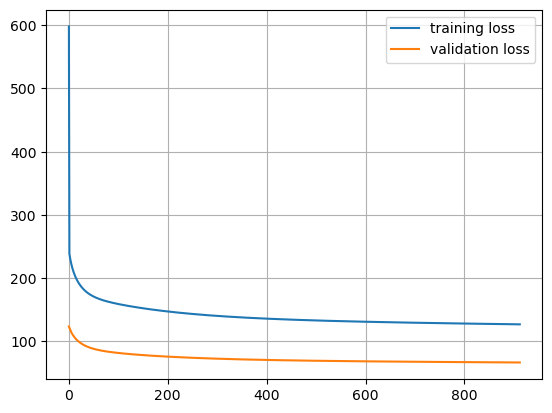

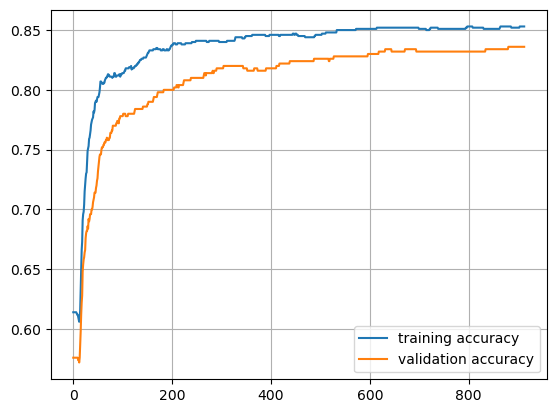

In [52]:
loss_train_list = cl_mlp.loss_train
loss_val_list = cl_mlp.loss_val

#print(loss_train_list)

accuracies_train_list = cl_mlp.accuracies_train
accuracies_val_list = cl_mlp.accuracies_val

epochs_axis = range(cl_mlp.number_of_epochs)

plt.plot(epochs_axis, loss_train_list, label="training loss")
plt.plot(epochs_axis, loss_val_list, label="validation loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs_axis, accuracies_train_list, label="training accuracy")
plt.plot(epochs_axis, accuracies_val_list, label="validation accuracy")
plt.legend()
plt.grid()
plt.show()


For the loss curves, it seems that the validation loss is always half the amount of the training loss.

For the accuracy curves, it seems that the curves aree quite similar.

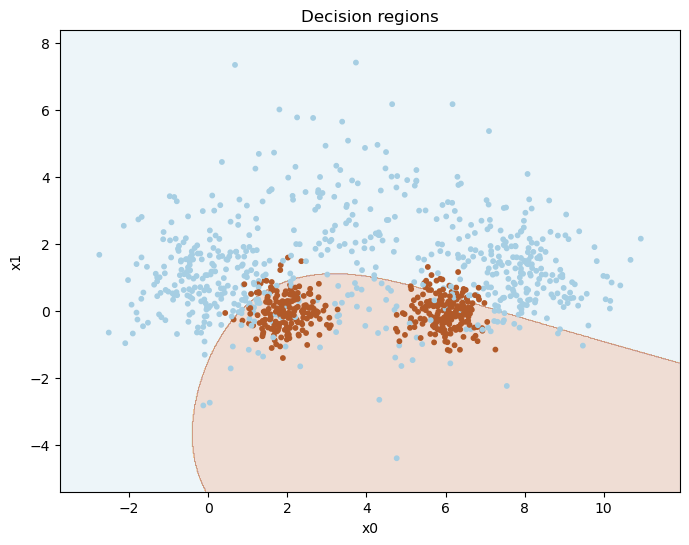

In [53]:
plot_decision_regions(X_train, t2_train, cl_mlp)

### Training 10 times with optimal hyperparameters and reporting accuracy

In [54]:
epochs = 100000
eta = 0.0001
tol = 0.5
dim_hidden = 36

list_of_accuracies = []

for i in range(0, 10):
    cl_mlp = MLPBinaryLinRegClass(dim_hidden=dim_hidden)
    cl_mlp.fit(X_train, t2_train, eta=eta, epochs=epochs, 
                X_val=X_val, t_val=t2_val, tol=tol, n_epochs_no_update = 100)
    
    list_of_accuracies.append(accuracy(cl_mlp.predict(X_val), t2_val))

mean_accuracy = sum(list_of_accuracies) / len(list_of_accuracies)
max_accuracy = max(list_of_accuracies)

print(f"Mean accuracy: {mean_accuracy} --- Max accuracy: {max_accuracy}")

Mean accuracy: 0.8423999999999999 --- Max accuracy: 0.852


## For IN4050-students: Multi-class neural network

The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. (This is the most fun part of the set :) )

The goal is to use a feed-forward network for non-linear multi-class classfication and apply it to set (X, t_multi).

Modify the netork to become a multi-class classifier. As a check of your implementation, you may apply it to (X, t_2) and see whether you get similar results as above.

Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Plot the decision boundaries for your best classifier..

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.

## For IN4050-students: Multi-class task (X, t_multi)
The following part is only mandatory for in4050-students. In3050-students are also welcome to do it. It requires the earlier IN4050-only tasks. 

Compare the three multi-class classfiers, the one-vs-rest and the multinomial logistic regression from part one, and the multi-class neural network from part two. Evaluate on test, validation and training set as above. 

Comment on what you see

### Binary task:

For this final testing, I have decided to train and test only with unscaled sets. The optimal hyperparameters for all the binary classifiers given unscaled sets are as following:

#### Linreg
eta = 0.01, epochs = 10 000

#### Logreg
eta = 0.1, tol = 5e-06, n_epochs_no_updates = 10

#### MLP
eta = 0.0001, tol = 0.5, n_epochs_no_update = 100, dim_hidden = 36



In [55]:
# Training linear regression classifier
eta_linreg = 0.01
epochs_linreg = 10000
cl_linreg_final = NumpyLinRegClass()
cl_linreg_final.fit(X_train, t2_train, eta=eta_linreg, epochs=epochs_linreg)

linreg_train_accuracy = accuracy(cl_linreg_final.predict(X_train), t2_train)
linreg_val_accuracy = accuracy(cl_linreg_final.predict(X_val), t2_val)
linreg_test_accuracy = accuracy(cl_linreg_final.predict(X_test), t2_test)

# Training logistic regression classifier
eta_logreg = 0.1
tol_logreg = 0.000005
cl_logreg_final = NumpyLogReg()
cl_logreg_final.fit(X_train, t2_train, eta=eta_logreg, epochs=100000, 
                    X_val=X_val, t_val=t2_val, tol=tol_logreg, n_epochs_no_update=10)

logreg_train_accuracy = accuracy(cl_logreg_final.predict(X_train), t2_train)
logreg_val_accuracy = accuracy(cl_logreg_final.predict(X_val), t2_val)
logreg_test_accuracy = accuracy(cl_logreg_final.predict(X_test), t2_test)

# Training multi-layer perceptron classifier
dim_hidden = 36
eta_mlp = 0.0001
tol_mlp = 0.5
cl_mlp_final = MLPBinaryLinRegClass(dim_hidden=dim_hidden)
cl_mlp_final.fit(X_train, t2_train, eta=eta_mlp, epochs=100000, 
                X_val=X_val, t_val=t2_val, tol=tol_mlp, n_epochs_no_update = 100)
    
mlp_train_accuracy = accuracy(cl_mlp_final.predict(X_train), t2_train)
mlp_val_accuracy = accuracy(cl_mlp_final.predict(X_val), t2_val)
mlp_test_accuracy = accuracy(cl_mlp_final.predict(X_test), t2_test)

# Reporting in a three by three table
three_by_three = "Classifier        train        val        test\n"
three_by_three += f"Linreg:           {linreg_train_accuracy}        {linreg_val_accuracy}        {linreg_test_accuracy}\n"
three_by_three += f"Logreg:           {logreg_train_accuracy}        {logreg_val_accuracy}        {logreg_test_accuracy}\n"
three_by_three += f"MLP   :           {mlp_train_accuracy}        {mlp_val_accuracy}        {mlp_test_accuracy}\n"
print(three_by_three)

Classifier        train        val        test
Linreg:           0.753        0.704        0.724
Logreg:           0.76        0.71        0.732
MLP   :           0.858        0.848        0.858



### Regarding the three by three table

It seems that for the linear regression classifier and logistic regrestion classifier, they are almost equally as good. With scaling they both would've been better, but then logistic regression would've dominated a little.

MLP is the best in all the three different sets.

Another observation is that for all the three sets, the accuracy is the highest for the training set. This does make sense though, since the classifiers are trained using that set. In contrast to the question about the validation set vs test set, it seems that the test set wins.

### Calculating precision and recall for class 1

In [56]:
def precision(y, t):
    len_t = t.shape[0]
    true_results = []
    false_results = []
    for i in range(len_t):
        if y[i] == t[i]:
            true_results.append(y[i])
        elif y[i] != t[i]:
            false_results.append(y[i])
    tp, fp = 0, 0
    for i in true_results:
        if i == 1:
            tp += 1
    for i in false_results:
        if i == 1:
            fp += 1
    precision = tp / (tp + fp)
    return precision

def recall(y, t):
    len_t = t.shape[0]
    true_results = []
    false_results = []
    for i in range(len_t):
        if y[i] == t[i]:
            true_results.append(y[i])
        elif y[i] != t[i]:
            false_results.append(y[i])
    tp, fn = 0, 0
    for i in true_results:
        if i == 1:
            tp += 1
    for i in false_results:
        if i == 0:
            fn += 1
    recall = tp / (tp + fn)
    return recall


In [57]:

def print_precisions_and_recalls(classifier, name):
    train_precision = precision(classifier.predict(X_train), t2_train)
    val_precision = precision(classifier.predict(X_val), t2_val)
    test_precision = precision(classifier.predict(X_test), t2_test)

    train_recall = recall(classifier.predict(X_train), t2_train)
    val_recall = recall(classifier.predict(X_val), t2_val)
    test_recall = recall(classifier.predict(X_test), t2_test)
    
    print(f"\nClassifier: {name}\n")
    print("            train                      val                      test")
    print(f"precision:  {train_precision}        {val_precision}        {test_precision}")
    print(f"recall   :  {train_recall}        {val_recall}        {test_recall}\n")
    print("----------------------------------------------------")

print_precisions_and_recalls(cl_linreg_final, "linreg")
print_precisions_and_recalls(cl_logreg_final, "logreg")
print_precisions_and_recalls(cl_mlp_final, "mlp")



Classifier: linreg

            train                      val                      test
precision:  0.6893732970027248        0.6818181818181818        0.6839080459770115
recall   :  0.655440414507772        0.5660377358490566        0.5891089108910891

----------------------------------------------------

Classifier: logreg

            train                      val                      test
precision:  0.6931216931216931        0.6871508379888268        0.6888888888888889
recall   :  0.6787564766839378        0.5801886792452831        0.6138613861386139

----------------------------------------------------

Classifier: mlp

            train                      val                      test
precision:  0.7824074074074074        0.8063063063063063        0.8075117370892019
recall   :  0.8756476683937824        0.8443396226415094        0.8514851485148515

----------------------------------------------------
